In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns

%matplotlib inline


/home/marcus/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('../data/preprocessed_data.csv')

In [3]:
df.head()

,Winner,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,Red,False,0.000000,0.0,0.420000,0.49500,0.330,0.36000,0.500000,1.000000,...,0,1,0,0,0,0,1,0,0,0
1,Red,False,0.500000,0.0,0.660000,0.30500,0.300,0.50000,1.500000,0.000000,...,0,1,0,0,0,0,1,0,0,0
2,Red,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,1,0,0,0,0,0,0,1,0
3,Blue,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,0,0,1,0,0,0,0,0,1
4,Blue,False,0.125000,0.0,0.535625,0.57875,0.185,0.16625,0.125000,0.187500,...,0,1,0,0,0,0,1,0,0,0


### Normalizing data

In [4]:
df_num = df.select_dtypes(include=[np.float, np.int])

In [5]:
scaler = StandardScaler()

df[list(df_num.columns)] = scaler.fit_transform(df[list(df_num.columns)])

### Splitting into train, test

In [6]:
y = df['Winner']
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

X = df.drop(columns = 'Winner')

X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=0.1, random_state=41)

### Fitting baseline Xgboost

In [7]:
def plot_confusion(cm):
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ax.set_ylim([0,2])

    ## Display the visualization of the Confusion Matrix.
    ax.invert_yaxis()
    plt.show()
    

In [8]:
def modelfit(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(f"Best number of estimators = {cvresult.shape[0]}")
    
    #Fit the algorithm on the data
    alg.fit(np.array(X_train), np.array(y_train), eval_metric='auc')
    
    #Predict train set:
    dtrain_predictions = alg.predict(np.array(X_train))
    dtrain_predprob = alg.predict_proba(np.array(X_train))[:,1]
        
    #Predict test set:
    dtest_predictions = alg.predict(np.array(X_test))
    dtest_predprob = alg.predict_proba(np.array(X_test))[:,1]
        
    #Print model report:
    print("\nModel Report: ")
    print(f"Accuracy (Test): {accuracy_score(y_test, dtest_predictions):.4f}")
#     print(f"AUC Score (Train): {roc_auc_score(y_train, dtrain_predprob)}")
    print(f"AUC Score (Test): {roc_auc_score(y_test, dtest_predprob):.4f}")
    
    
    return dtest_predictions

Best number of estimators = 100

Model Report: 
Accuracy (Test): 0.6802
AUC Score (Test): 0.7144


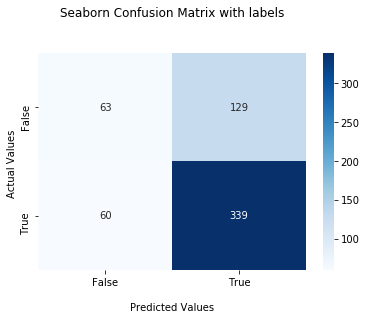

In [9]:
model1 = XGBClassifier(random_state=43, n_jobs=-1)

y1_preds = modelfit(model1, X_train, y_train, X_test, y_test)

cm = confusion_matrix(y_test, y1_preds)

plot_confusion(cm)

In [10]:
feat_imps = {}
for i, imp in enumerate(model1.feature_importances_):
    feat_imps[X_train.columns[i]] = imp

sorted_imp_feats = (sorted(feat_imps.items(), key = lambda x: x[1], reverse=True))
sorted_imp_feats

[('B_avg_SIG_STR_att', 0.023344433),
 ('R_avg_opp_DISTANCE_landed', 0.016146472),
 ('B_avg_DISTANCE_landed', 0.013202856),
 ('R_win_by_Decision_Split', 0.013020599),
 ('R_win_by_Decision_Majority', 0.012823383),
 ('B_win_by_Decision_Unanimous', 0.012211408),
 ('R_avg_opp_HEAD_landed', 0.011618251),
 ('weight_class_OpenWeight', 0.011387692),
 ('B_total_title_bouts', 0.011319535),
 ('B_avg_opp_DISTANCE_att', 0.010936261),
 ('weight_class_Featherweight', 0.010793519),
 ('B_Weight_lbs', 0.010521113),
 ('R_current_win_streak', 0.010281329),
 ('R_Weight_lbs', 0.009999626),
 ('R_Stance_Orthodox', 0.009678324),
 ('B_current_lose_streak', 0.009228317),
 ('B_avg_opp_HEAD_landed', 0.008967554),
 ('R_age', 0.008891735),
 ('B_Reach_cms', 0.008762539),
 ('B_avg_GROUND_landed', 0.008555696),
 ('B_age', 0.008554061),
 ('B_avg_HEAD_att', 0.008531591),
 ('B_avg_opp_SIG_STR_landed', 0.008488619),
 ('title_bout', 0.008259865),
 ('R_win_by_TKO_Doctor_Stoppage', 0.008237441),
 ('R_avg_opp_SIG_STR_pct', 0.00

### Since dataset is imbalanced let's try setting scale_pos_weight to see if we get an improvement

Best number of estimators = 19

Model Report: 
Accuracy (Test): 0.6904
AUC Score (Test): 0.7025


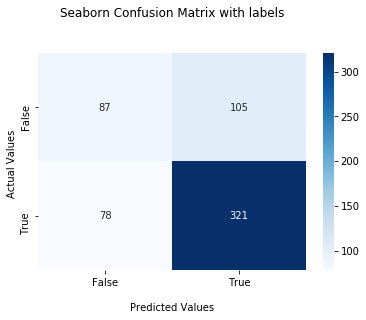

In [11]:
model2 = XGBClassifier(random_state=43, n_jobs=-1, scale_pos_weight=0.7)

y2_preds = modelfit(model2, X_train, y_train, X_test, y_test)

cm = confusion_matrix(y_test, y2_preds)

plot_confusion(cm)

### Hyperparameter tuning 

Best number of estimators = 76

Model Report: 
Accuracy (Test): 0.6937
AUC Score (Test): 0.7137


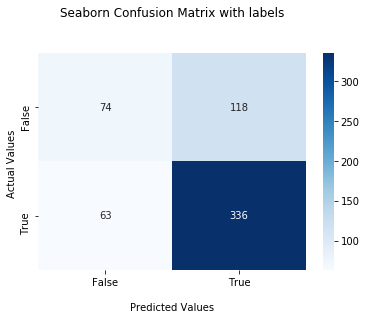

In [12]:
model3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=0.75,
)

y3_preds = modelfit(model3, X_train, y_train, X_test, y_test)

cm = confusion_matrix(y_test, y3_preds)

plot_confusion(cm)

### Oversampling

In [13]:
from imblearn.over_sampling import ADASYN

In [14]:
over_sampler = ADASYN()
X_resampled, y_resampled = over_sampler.fit_resample(X_train, y_train)

In [15]:
pd.Series(y_resampled).value_counts()

1    3580
0    3504
dtype: int64

Best number of estimators = 100

Model Report: 
Accuracy (Test): 0.6954
AUC Score (Test): 0.7096


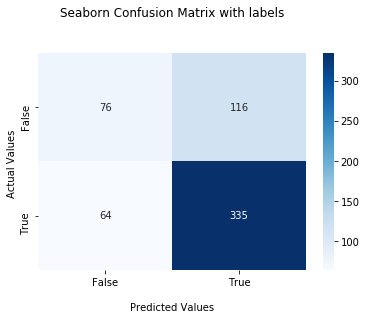

In [16]:
model4 = XGBClassifier(n_jobs=-1, random_state=43)

y4_preds = modelfit(model4, X_resampled, y_resampled, X_test, y_test)

cm = confusion_matrix(y_test, y4_preds)

plot_confusion(cm)

### Hyperparameter tuning for the oversampled data

Best number of estimators = 244

Model Report: 
Accuracy (Test): 0.6904
AUC Score (Test): 0.7089


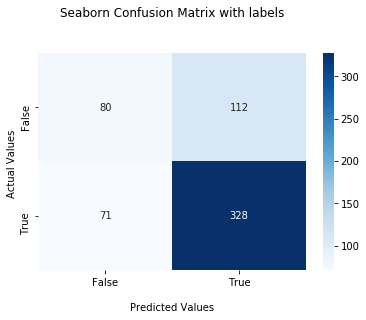

In [17]:
model5 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=244,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
)

y5_preds = modelfit(model5, X_resampled, y_resampled, X_test, y_test)

cm = confusion_matrix(y_test, y5_preds)

plot_confusion(cm)


Model Report: 
Accuracy (Test): 0.6971
AUC Score (Test): 0.7196


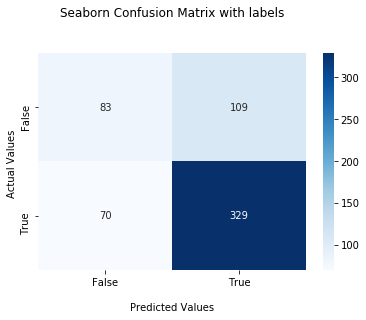

In [18]:
model6 = XGBClassifier(learning_rate =0.1, n_estimators=244, max_depth=4,
                     min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                     objective= 'binary:logistic', reg_alpha= 0, scale_pos_weight=1)

y6_preds = modelfit(model6, X_resampled, y_resampled, X_test, y_test, useTrainCV=False)

cm = confusion_matrix(y_test, y6_preds)

plot_confusion(cm)

In [19]:
X_os, y_os = X_resampled, y_resampled = over_sampler.fit_resample(X, label_encoded_y)

In [20]:
print(classification_report(y_test, y1_preds))

              precision    recall  f1-score   support

           0       0.51      0.33      0.40       192
           1       0.72      0.85      0.78       399

    accuracy                           0.68       591
   macro avg       0.62      0.59      0.59       591
weighted avg       0.66      0.68      0.66       591



In [21]:
print(classification_report(y_test, y2_preds))

              precision    recall  f1-score   support

           0       0.53      0.45      0.49       192
           1       0.75      0.80      0.78       399

    accuracy                           0.69       591
   macro avg       0.64      0.63      0.63       591
weighted avg       0.68      0.69      0.68       591



In [22]:
print(classification_report(y_test, y3_preds))

              precision    recall  f1-score   support

           0       0.54      0.39      0.45       192
           1       0.74      0.84      0.79       399

    accuracy                           0.69       591
   macro avg       0.64      0.61      0.62       591
weighted avg       0.68      0.69      0.68       591



In [23]:
print(classification_report(y_test, y4_preds))

              precision    recall  f1-score   support

           0       0.54      0.40      0.46       192
           1       0.74      0.84      0.79       399

    accuracy                           0.70       591
   macro avg       0.64      0.62      0.62       591
weighted avg       0.68      0.70      0.68       591



In [24]:
print(classification_report(y_test, y5_preds))

              precision    recall  f1-score   support

           0       0.53      0.42      0.47       192
           1       0.75      0.82      0.78       399

    accuracy                           0.69       591
   macro avg       0.64      0.62      0.62       591
weighted avg       0.68      0.69      0.68       591



In [25]:
print(classification_report(y_test, y5_preds))

              precision    recall  f1-score   support

           0       0.53      0.42      0.47       192
           1       0.75      0.82      0.78       399

    accuracy                           0.69       591
   macro avg       0.64      0.62      0.62       591
weighted avg       0.68      0.69      0.68       591



In [26]:
print(classification_report(y_test, y6_preds))

              precision    recall  f1-score   support

           0       0.54      0.43      0.48       192
           1       0.75      0.82      0.79       399

    accuracy                           0.70       591
   macro avg       0.65      0.63      0.63       591
weighted avg       0.68      0.70      0.69       591



In [29]:
model = model6

model.fit(np.array(X_os), np.array(y_os))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=244, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
with open('../data/model-new.sav', 'wb') as mdl:
    pickle.dump(model, mdl)